In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda:0'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
k = 1

In [6]:
from dyck_k_generator.generator import generate_dataset

generate_dataset(
    n=10_000,
    k=k,
    max_length=10,
    balanced=0.6,
)

Generating unbalanced strings: 100%|██████████| 4000/4000 [00:00<00:00, 77787.90it/s]
Saving dataset to data/dyck-1_10000-samples_10-len_p06.jsonl: 100%|██████████| 10000/10000 [00:00<00:00, 634414.41it/s]

Dataset saved to data/dyck-1_10000-samples_10-len_p06.jsonl


In [7]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()'

In [8]:
from dataset.dataset import DyckLanguageDataset

In [9]:
dataset = DyckLanguageDataset("data/dyck-1_10000-samples_10-len_p06.jsonl", VOCAB).to(device)

Loaded 10000 samples from data/dyck-1_10000-samples_10-len_p06.jsonl


Tokenizing strings: 100%|██████████| 10000/10000 [00:00<00:00, 712432.52it/s]


In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [12]:
from torch.utils.data import DataLoader

In [25]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Manual Transformer + BERTViz


In [32]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    pad_token_mask,
)

In [33]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=128,
    n_heads=1,
    dim_ff=256,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
)

In [34]:
model = TransformerClassifier(model_config)

In [35]:
model.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 128)
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=128, out_features=128, bias=True)
          (k_linear): Linear(in_features=128, out_features=128, bias=True)
          (v_linear): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=128, out_features=128, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=256, out_features=128, bias=True)
        )
        (ln1): La

In [36]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [42]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=10,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask=True,
)

Epoch 1/10


  0%|          | 0/125 [00:00<?, ?it/s]

Batch 100/125 | Loss: 0.0001 | Acc: 100.00%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0140 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 2/10


  0%|          | 0/125 [00:00<?, ?it/s]

Batch 100/125 | Loss: 0.0001 | Acc: 100.00%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0129 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 3/10


  0%|          | 0/125 [00:00<?, ?it/s]

Batch 100/125 | Loss: 0.0001 | Acc: 100.00%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0121 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 4/10


  0%|          | 0/125 [00:00<?, ?it/s]

Batch 100/125 | Loss: 0.0001 | Acc: 100.00%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0112 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 5/10


  0%|          | 0/125 [00:00<?, ?it/s]

Batch 100/125 | Loss: 0.0001 | Acc: 100.00%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0103 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 6/10


  0%|          | 0/125 [00:00<?, ?it/s]

Batch 100/125 | Loss: 0.0001 | Acc: 100.00%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0098 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 7/10


  0%|          | 0/125 [00:00<?, ?it/s]

Batch 100/125 | Loss: 0.0001 | Acc: 100.00%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0092 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 8/10


  0%|          | 0/125 [00:00<?, ?it/s]

Batch 100/125 | Loss: 0.0001 | Acc: 100.00%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0086 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 9/10


  0%|          | 0/125 [00:00<?, ?it/s]

Batch 100/125 | Loss: 0.0001 | Acc: 100.00%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0081 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 10/10


  0%|          | 0/125 [00:00<?, ?it/s]

Batch 100/125 | Loss: 0.0001 | Acc: 100.00%


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0077 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%


In [43]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Batch 100/100 | Loss: 0.0000 | Acc: 100.00%
Test Loss: 0.0027 | Test Acc: 100.00%


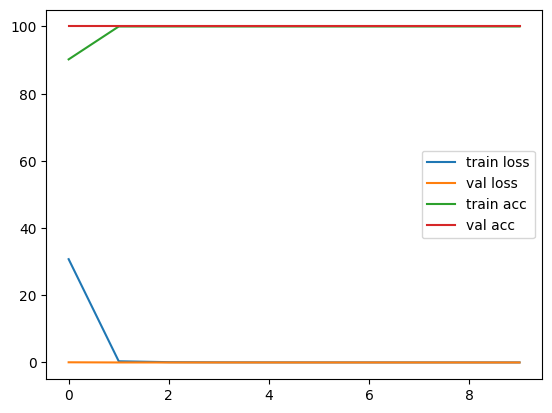

In [41]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [38]:
batch = next(iter(test_dataloader))
strings, labels, tokens = batch

mask = pad_token_mask(tokens)
attn_matrices = model.get_attn_matrices(tokens, mask)

In [ ]:
print(strings[0], tokens[0], labels[0])

In [ ]:
attn_matrices[0].shape

In [ ]:
attn_matrix = attn_matrices[0][0]
attn_matrix[0]

In [ ]:
from dataset.dataset import DyckLanguageTokenizer

In [ ]:
tokenizer = DyckLanguageTokenizer(VOCAB)

In [ ]:
labels = tokenizer.decode_single(tokens[0], remove_special_tokens=False).split(" ")
x_ticks = list(i for i in range(attn_matrices[0][0][0].shape[0]))
y_ticks = list(i for i in range(attn_matrices[0][0][0].shape[1]))

In [ ]:
len(strings[0])

In [ ]:
attn_matrices[0][0][0].shape

In [ ]:
import numpy as np


def z_score_normalize(matrix):
    mean = np.mean(matrix)
    std = np.std(matrix)
    normalized_matrix = (matrix - mean) / std
    return normalized_matrix


def min_max_normalize(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix

In [ ]:
import matplotlib.pyplot as plt

# plot heatmap of first attention matrix
plt.figure(figsize=(10, 10))
heatmap = plt.imshow(
    min_max_normalize(attn_matrices[0][0][0].cpu().detach().numpy()),
    cmap="coolwarm",
    interpolation="nearest",
)

plt.xticks(ticks=x_ticks, labels=labels)
plt.yticks(ticks=y_ticks, labels=labels)
cbar = plt.colorbar(heatmap)
cbar.set_label("Attention weights")
plt.show()

In [ ]:
minimax_norm = min_max_normalize(attn_matrices[0][0][0].cpu().detach().numpy())

In [ ]:
minimax_norm[11][11]